<div style="display: flex; align-items: center;margin-bottom: 30px;color: #8EB944">
    <img src=https://wisoinbox.uni-koeln.de/images/wiso_button_en.png width="80"> 
    <span style="margin-left: 20px;font-size: 50px;font-weight:bold";>Group Project: Predictive Analytics</span>
</div>

<div>
    <span style="font-size: 20px;font-weight: bold";>Group Members:</span>

<ul>
    <li>Tom Boerrigter | 7419077</li>
    <li>Niklas Sterz | 7419545</li>
</ul>
</div>

# Day 2
# a)
### Fit one or more reasonable regression models and to interpret your results.

### Convert the variables

In [4]:
# Since more people are cycling on the weekend, it is useful to implement a indicator variable that is 0 for the weekend and 1 for every other day
rides_daily['weekday_new'] = rides_daily['weekday'].apply(lambda  x: np.int16(x in ['Wed', 'Thu', 'Fri', 'Mon', 'Tue']))
rides_daily['Saturday'] = rides_daily['weekday'].apply(lambda x: np.int16(x in['Sat']))
rides_daily['Sunday'] = rides_daily['weekday'].apply(lambda x: np.int16(x in['Sun']))

# People are cycling very often during the day and just sparsely during the night. So we introduce a binary variable 'day' for the time between 12am and 8pm.
# Furthermore the variable 'night' includes the time between 11pm and 6am. This is where very few people seem to cycle.
rides_daily['day'] = rides_daily['hour'].apply(lambda  x: np.int16(x in list(range(12,20))))
rides_daily['night'] = rides_daily['hour'].apply(lambda  x: np.int16(x in [0,1,2,3,4,5,6,23]))

# The meteorological seasons also have an impact on the number of rides. Most people are more likely to cycle during the summer months than 
# during the colder seasons. To take this into account we apply the variables 'Spring', 'Summer', 'Autumn' and 'Winter'.
rides_daily['Spring'] = rides_daily['month'].apply(lambda  x: np.int16(x in ['Mar', 'Apr', 'May']))  
rides_daily['Summer'] = rides_daily['month'].apply(lambda  x: np.int16(x in ['Jun', 'Jul', 'Aug']) )  
rides_daily['Autumn'] = rides_daily['month'].apply(lambda  x: np.int16(x in ['Sep', 'Oct', 'Nov']))   
rides_daily['Winter'] = rides_daily['month'].apply(lambda  x: np.int16(x in ['Dec', 'Jan', 'Feb']))

# Bad Weather also has an impact on the number of rides. Since rain is one of the most important indicators of bad weather, we introduce the variable 'heavy_rain'.
# It is reasonable to assume, that some light drops of rain don't impact the number of rides much. Heavy Rain on the other side could be a reason 
# to use another mode of transportation. Therefore, we set the threshold to 3mm of rain.
rides_daily['heavy_rain'] = rides_daily['precip'].apply(lambda  x: np.int16(x >=3))

# The variables 'temp' and 'feelslike' seem to be one of the main contributors to the number of rides. Since the variable 'feelslike' has a high 
# correlation with 'temp' the introduction of both into the model would lead to multicollinearity.
# Nevertheless, people are, given the same temperature, more unlikely to rent bicyle if the temperature feels colder than it actually is. This leads to the binary
# variable, 'feels_colder', which takes the value 1 for days where the perceived temperature is colder than the actual one and 0 otherwise.
rides_daily['feels_colder'] = (rides_daily['feelslike'] < rides_daily['temp']).astype(np.int16)

# Snow also seems to have a big impact on the number of rides, since snow makes much more unsafe and harder to bike. Since a bit of snow most likely won't make
# a difference, we consider anything above 2mm as heavy snow.
rides_daily['heavy_snow'] = rides_daily['snowdepth'].apply(lambda x: np.int16(x > 2))

In [24]:
rides_daily.drop('month',axis=1,inplace=True) #Drop the old variables to clean up the DataFrame
rides_daily.drop('hour',axis=1,inplace=True)
rides_daily.drop('weekday',axis=1,inplace=True)
rides_daily.columns

Index(['num_rides', 'cloudcover', 'dew', 'feelslike', 'feelslikemax',
       'feelslikemin', 'humidity', 'moonphase', 'precip', 'precipcover',
       'precipprob', 'sealevelpressure', 'severerisk', 'snow', 'snowdepth',
       'solarenergy', 'solarradiation', 'temp', 'tempmax', 'tempmin',
       'uvindex', 'visibility', 'winddir', 'windgust', 'windspeed',
       'weekday_new', 'Saturday', 'Sunday', 'day', 'night', 'Spring', 'Summer',
       'Autumn', 'Winter', 'heavy_rain', 'feels_colder', 'heavy_snow'],
      dtype='object')

## Regression 

### Multiple linear regression without weather data

In [5]:
# Choosing the independent variables to include in the model. To avoid the "Dummy Variable Trap", we leave out one binary variable for the months, the days
# and the hours.
design = MS(['Summer','Winter','Autumn','night','day','weekday_new','Sunday'])


design = design.fit(rides_daily) 
X = design.transform(rides_daily)

# Adding a constant to the model
X = sm.add_constant(X)

# Setting the number of rides as the dependent variable
y = rides_daily['num_rides']

# Function to calculate VIF
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [1 / (1 - results.rsquared) for results in [sm.OLS(data_frame[col], data_frame.drop(columns=[col])).fit() for col in data_frame.columns]]

    return vif_data

# Calculate VIF for your X DataFrame
vif_values = calculate_vif(X)

# Fitting the model
model = sm.OLS(y,X)
results = model.fit()

# Print the results of the model and the VIF values
print(results.summary(),'\n','RSquared:',results.rsquared.round(4),'\n','RSE:',np.sqrt(results.scale).round(4),'\n',vif_values)

                            OLS Regression Results                            
Dep. Variable:              num_rides   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     2476.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:51:16   Log-Likelihood:            -1.2790e+05
No. Observations:               23352   AIC:                         2.558e+05
Df Residuals:                   23344   BIC:                         2.559e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      58.5247      1.287     45.466      

This model serves as a good baseline. It doesn't include any weather data but already has an R^2 and adjusted R^2 of 0.426. The VIF values also suggest, that there are no problems with multicollinearity. In the next regression the weather data will be added to this baseline model.

In [26]:
# Choosing the independent variables to include in the model
design = MS(['Summer','Winter','Autumn','night','day','weekday_new','Sunday','precipcover',
             'temp','cloudcover','precipprob',poly('humidity',degree = 2),'heavy_snow',
             'windspeed','uvindex','heavy_rain','severerisk'])

design = design.fit(rides_daily) 
X = design.transform(rides_daily)

# Adding a constant to the model
X = sm.add_constant(X)

# Setting the number of rides as the dependent variable
y = rides_daily['num_rides']

# Function to calculate VIF
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [1 / (1 - results.rsquared) for results in [sm.OLS(data_frame[col], data_frame.drop(columns=[col])).fit() for col in data_frame.columns]]

    return vif_data

# Calculate VIF for your X DataFrame
vif_values = calculate_vif(X)

# Fitting the model
model = sm.OLS(y,X)
results = model.fit()

# Print the results of the model and the VIF values
print(results.summary(),'\n','RSquared:',results.rsquared.round(4),'\n','RSE:',np.sqrt(results.scale).round(4),'\n',vif_values)

                            OLS Regression Results                            
Dep. Variable:              num_rides   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     1301.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:22:51   Log-Likelihood:            -1.2627e+05
No. Observations:               23352   AIC:                         2.526e+05
Df Residuals:                   23333   BIC:                         2.527e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept         

The R^2 is now above 0.5. But there are multiple problems with the interpretation and multicollinearity. First, 'severerisk' which quantifies the likelyhood of a severe weather event like a storm, is posetively correlated with the number of rides. This is due to severe storms beeing more likely to occur in the summer months. The same problem applies to 'cloudcover' and 'precipprob'. The VIF of 'temp' is also very high, most likely due to the high number of weather variables which all correlate with the temperature. We apply this knowledge to the next and- final model.

In [6]:
# Choosing the independent variables to include in the model
design = MS(['Summer','Winter','Autumn','night','day','weekday_new','Sunday',
             'temp',poly('humidity',degree = 2),'heavy_snow'
            ,'heavy_rain'])

design = design.fit(rides_daily) 
X = design.transform(rides_daily)

# Adding a constant to the model
X = sm.add_constant(X)

# Setting the number of rides as the dependent variable
y = rides_daily['num_rides']

# Function to calculate VIF
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [1 / (1 - results.rsquared) for results in [sm.OLS(data_frame[col], data_frame.drop(columns=[col])).fit() for col in data_frame.columns]]

    return vif_data

# Calculate VIF for your X DataFrame
vif_values = calculate_vif(X)

# Fitting the model
model = sm.OLS(y,X)
results = model.fit()

# Print the results of the model and the VIF values
print(results.summary(),'\n','RSquared:',results.rsquared.round(4),'\n','RSE:',np.sqrt(results.scale).round(4),'\n',vif_values)

                            OLS Regression Results                            
Dep. Variable:              num_rides   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     1742.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:53:35   Log-Likelihood:            -1.2692e+05
No. Observations:               23352   AIC:                         2.539e+05
Df Residuals:                   23339   BIC:                         2.540e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept         

## Make predictions with this third model.

In [7]:
# The first prediction is December at midnight, 
# The second one June at midday and the third one a Septembre day with a severe storm
new_df = pd.DataFrame({'Summer':[0,1,0],
                       'Winter':[1,0,0],
                       'Autumn':[0,0,0],
                       'night':[1,0,0],
                       'day':[0,1,0],
                       'weekday_new':[1,0,0],
                       'Sunday':[0,1,1],
                       'temp':[3.7,26.9,26.6],
                       'humidity':[45.5,67.9,63.6],
                       'heavy_snow':[0,0,0],
                       'uvindex':[5,9,10],
                       'heavy_rain':[0,0,1],
                      }) 
newX = design.transform(new_df)
new_predictions = results.get_prediction(newX);
print('Predicted values:',new_predictions.predicted_mean.round(0))

Predicted values: [ -8. 161.  90.]


Interpreation: All of the selected variables seem to be statistically significant with all of them having a p-value well below 0.05. Furthermore the R2 suggests, that 
47.5% of the variance can be explained with the model. All VIF-Values are under five which indicates that there is no problem with multicollinearty. The baseline, that is, the intercept, predicts roughly 9 rides. This includes the dummies that were not considered in the variable selection. The warmer months: summer and autumn predict a higher number of rides than winter or spring. Furthermore, many people seem to ride at daytime, while very few do at nightime; some doing the time between. Saturday has the highest coefficient, with both the dummies  for sunday and the weekdays worsening the predictions. Severe weather conditions like rain and snow further worsen the results. There are also problems associated with the nature of linear regressions. The model can predict negative values, especially at night and when the temperature is low. For instance, the first prediction for a cold december night is -8.

In [8]:
# Calculate the training MSE
X_valid = design.transform(rides_daily) 
y_valid = rides_daily['num_rides'] 
valid_pred = results.predict(X_valid)
print('The Training MSE is',np.mean((y_valid - valid_pred)**2).round(4))

The Training MSE is 3078.6641


Training MSE: The training MSE is roughly 3079, keep that in mind for Day 6.

# b)

### plot the residuals and describe what you see

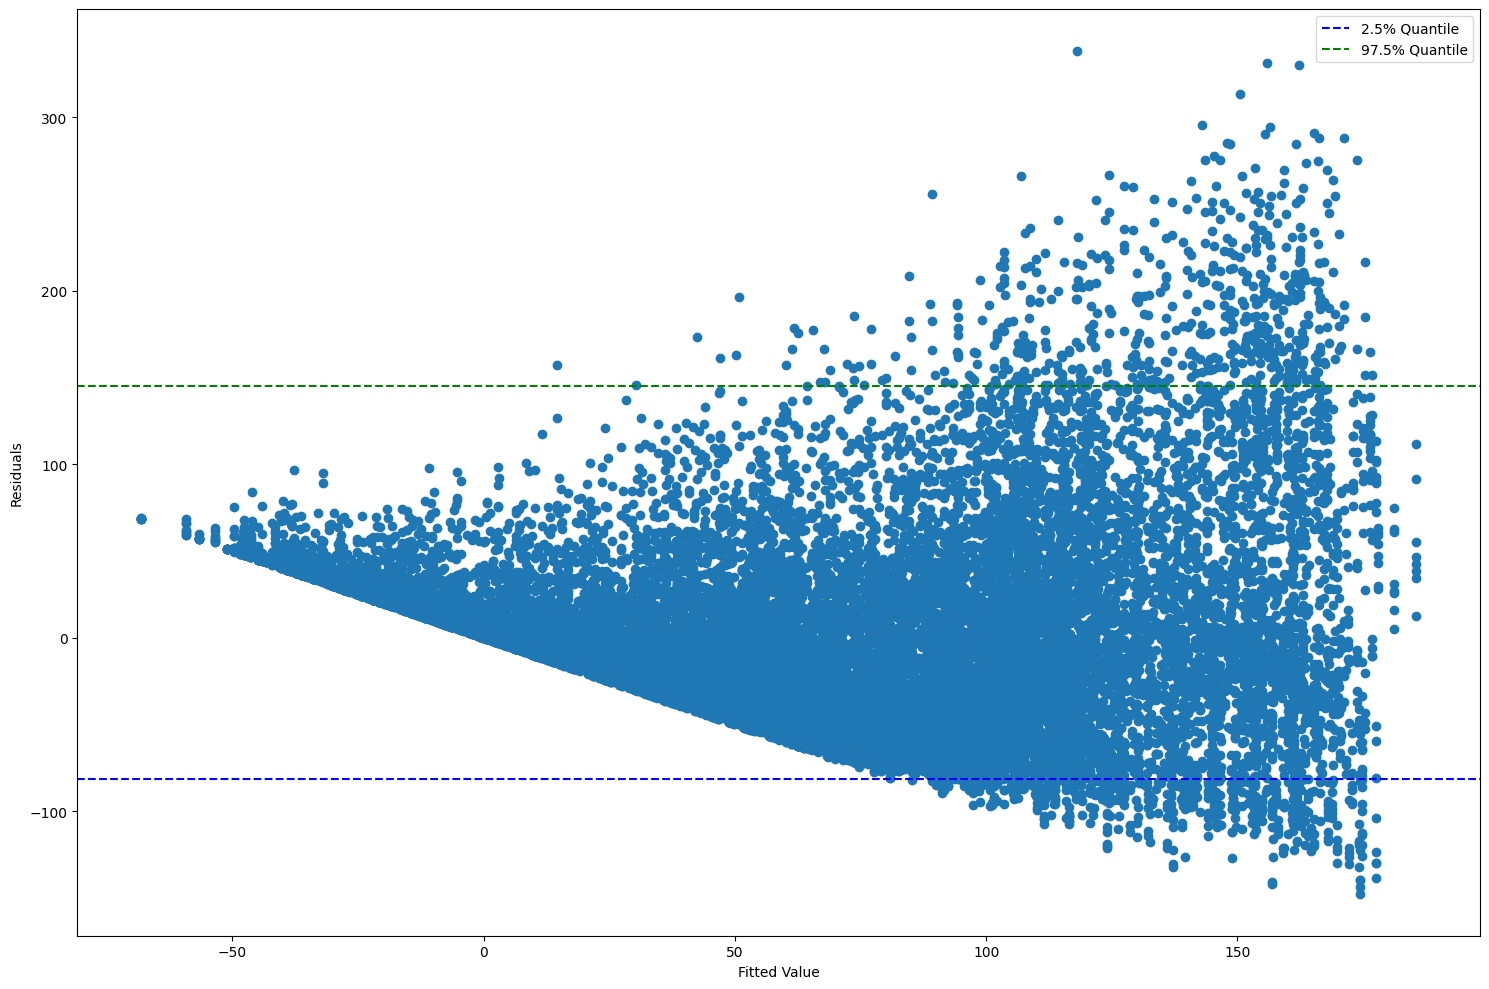

In [9]:
# get the residuals from the final model in a)
residuals = results.resid



# Create a scatter plot of residuals
fig, axs = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=False, tight_layout=True, figsize=(15, 10))
axs.scatter(results.fittedvalues, residuals)
axs.set_xlabel('Fitted Value')
axs.set_ylabel('Residuals')

# Calculate quantiles for the residuals --> 95 % confidence interval
q1, q2 = np.percentile(residuals, [2.5, 97.5])

# Add lines for the outer quantiles
axs.axhline(q1, c='blue', linestyle='--', label='2.5% Quantile')
axs.axhline(q2, c='green', linestyle='--', label='97.5% Quantile')

axs.legend()


Interpretation: This plot shows the residuals of the regression from the third model in a). Since it is a multiple linear regression, we can't show them for every variable in a two dimensional space. Therefore, this shows the 'Fitted Value' on the X-Axis, which is the value our model predicted and the Residuals on the Y-Axis. It is obvious that for every prediction above zero, the residual can't be greater below zero than the fitted value, since there are no Data Points below zero. For example, if our prediction is 50, the residual can't be below -50. This causes there to be the smooth line path of observations at the bottom of the plot. Since the RSE is about 55, most residuals are in the range of +50 and -50. There are some hours in the dataset which have extreme values. That explains the high residuals in the top right corner. Furthermore, there are more positive outliers than negative ones, meaning the true value is closer to our prediction when the predicition is higher than the true value. The funnel shape of the plot also indicates that there is quite a large problem of heteroscedasticty it. That is, it is safe to assume that the error terms do not have a constant variance which is one of the assumptions of the linear model.

# Day 3

## Code for the creation of the confusion matrix the guru provided with some small adjustments:

In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = (np.trace(cf) / float(np.sum(cf)))*100

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            specificity = (cf[0,0] / sum(cf[0,:]))*100
            precision = (cf[1,1] / sum(cf[:,1]))*100
            recall    = (cf[1,1] / sum(cf[1,:]))*100
            f1_score  = (2*precision*recall / (precision + recall))
            stats_text = "\n\nAccuracy={:0.2f}%\nPrecision={:0.2f}%\nRecall/ Sensitivity={:0.2f}%\nF1 Score={:0.3f}\nSpecificity={:0.2f}%".format(
                accuracy,precision,recall,f1_score,specificity)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## a)

# Importing the data and the test-train-split

In [11]:
test = pd.read_csv('test.csv')
train = pd.read_csv('maintenance_train.csv')
predictive_maintenance = pd.read_csv('predictive_maintenance.csv')

In [12]:
#converting the categorical variable Type into two binary variables

predictive_maintenance['Type_L'] = predictive_maintenance['Type'].apply(lambda x: np.int64(x == 'L'))
predictive_maintenance['Type_H'] = predictive_maintenance['Type'].apply(lambda x: np.int64(x == 'H'))

train['Type_L'] = train['Type'].apply(lambda x: np.int64(x == 'L'))
train['Type_H'] = train['Type'].apply(lambda x: np.int64(x == 'H'))

test['Type_L'] = train['Type'].apply(lambda x: np.int64(x == 'L'))
test['Type_H'] = train['Type'].apply(lambda x: np.int64(x == 'H'))


# Visualization of the relationship of the data in a correlation matrix

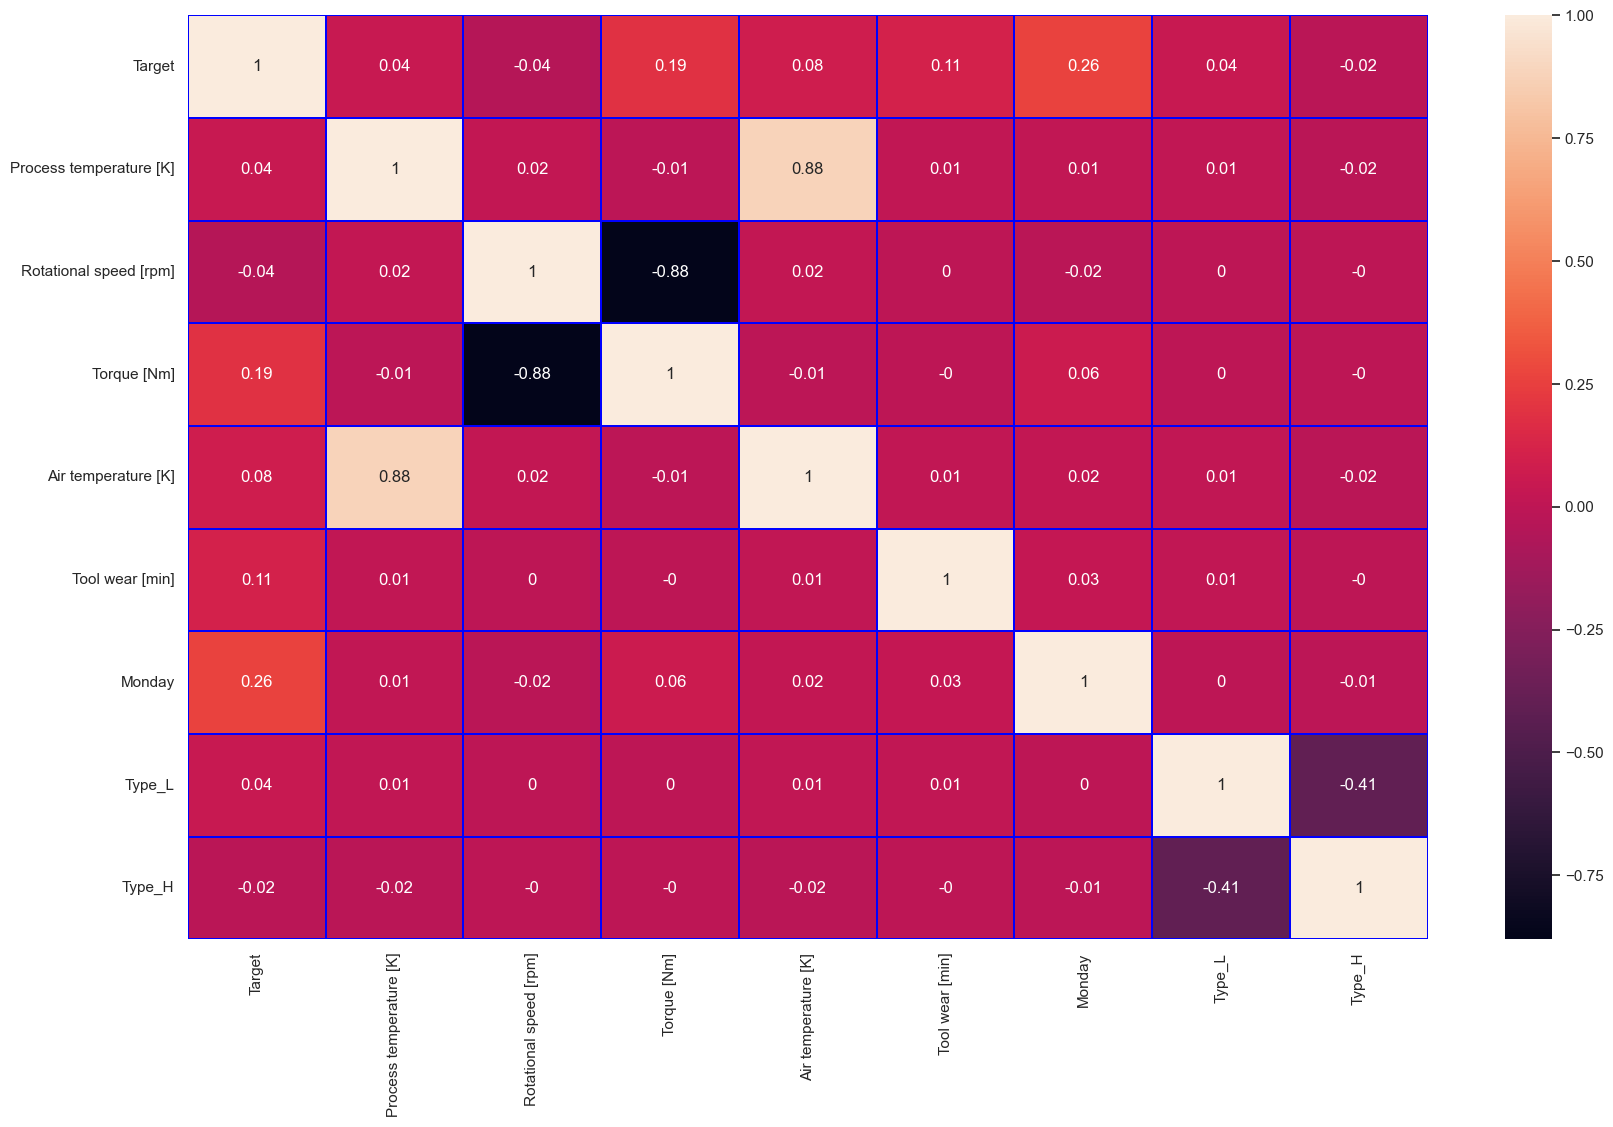

In [13]:
# Create a correlation matrix for all variables except 'Failure Type' and round the results
correlation_matrix = predictive_maintenance[['Target',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Air temperature [K]',
       'Tool wear [min]','Failure Type', 'Monday', 'Type_L','Type_H']].corr(numeric_only=True).round(2)

# Set size of the figure
sns.set(rc={'figure.figsize':(20,12)}) 

#Plot a heatmap of the correlation matrix
sns.heatmap(data=correlation_matrix, annot=True, linewidths=0.3,linecolor='blue'); # annot = True to print the values inside the square


The highest correlation between the target variable and an independent variable is with the binary variable 'Monday' and the continous variable 'Torque'. One would expect these two variables to be the strongest predictors. The other variables also have small correlations with the dependend variable, therefore we first fit a model with the entire set of predictor variables.

# Model 1 ( baseline model with all predictors)

## Logistic Regression Model

In [14]:
# We decided to use Logistic Regression for our predictions after trying out the other methods like LDA and KNN which yielded worse results than logistic regression. 
# One possible explanation for that might be that none of the predictors have a normal distribution , which is assumed by LDA and QDA.

# Transforming the set of predictors for the test-train split
design_train1 = MS(['Air temperature [K]', 
         'Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]',
       'Tool wear [min]','Monday', 'Type_L', 'Type_H'])
X_train1 = design_train1.fit_transform(train)
y_train1 = train.Target == 1  # predict a failure Target==1


design_test1 = MS(['Air temperature [K]',
         'Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]',
       'Tool wear [min]','Monday', 'Type_L', 'Type_H'])
X_test1 = design_test1.fit_transform(test)
y_test1 = test.Target == 1


# Fitting the model for the logistic regression on the training data
glm = sm.GLM(y_train1, X_train1, family=sm.families.Binomial())
results = glm.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Target   No. Observations:                 7500
Model:                            GLM   Df Residuals:                     7491
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -577.35
Date:                Wed, 29 Nov 2023   Deviance:                       1154.7
Time:                        18:57:15   Pearson chi2:                 5.50e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1369
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

Takeaway: The p-values for 'Type_L' and 'Type_H' indicate that there is most likely no relationship between the Product Type and the the target variable.
In other words, failures are not more common for any of the three product types.

# Model 2

Model 1 serves as a baseline, in Model 2 we remove the variables 'Type_L' and 'Type_H', since they are  most likely not associated with the target variable. Furthermore, we improve the fit of the logistic regression (Pseudo R^2) by adding interaction terms to the model.

## Interaction terms

We have tested a majority of all possible interaction terms and found that the following two improve the fit of the regression (training error) as well as the test error. That is, adding theso two interaction terms improves both the recall and the precision of the model. Other possible interaction terms did not result in an improvement of these two metrics and most of them also did not even improve the training error. Additionally, we tested wheter any of the non-categorical variables of the baseline model might have a quadratic or cubic relationship with the dependent variable. We did not find evidence for such a relationship insofar as that all of them increased the test error (either the accuracy or the precision or both suffered from adding quadratic or cubic terms).


### Create interaction terms

In [15]:
test['Interaction_1'] = test['Rotational speed [rpm]']*test['Torque [Nm]']
train['Interaction_1'] = train['Rotational speed [rpm]']*train['Torque [Nm]']

test['Interaction_2'] = test['Tool wear [min]']*test['Air temperature [K]']
train['Interaction_2'] = train['Tool wear [min]']*train['Air temperature [K]']


In [19]:
# choose all the predictors that had a p-value below 0.05 from the baseline model and add the interaction terms defined above 
design_train2 = MS(['Air temperature [K]', 'Interaction_1', 'Interaction_2',
         'Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]',
       'Tool wear [min]','Monday'])
X_train2 = design_train2.fit_transform(train)
y_train2 = train.Target == 1  # predict a failure Target==1


design_test2 = MS(['Air temperature [K]', 'Interaction_1', 'Interaction_2',
         'Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]',
       'Tool wear [min]','Monday'])
X_test2 = design_test2.fit_transform(test)
y_test2 = test.Target == 1

# initialise and fit the  model on the new set of predictors for the training data
glm = sm.GLM(y_train2, X_train2, family=sm.families.Binomial())
results2 = glm.fit()

# print the regression output
print(results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Target   No. Observations:                 7500
Model:                            GLM   Df Residuals:                     7491
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -531.35
Date:                Wed, 29 Nov 2023   Deviance:                       1062.7
Time:                        18:57:51   Pearson chi2:                 5.04e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                -

The regression output above indicates that all variables in the model seem to be associated with the dependent variable and the training error decreased from the baseline model.

To see how well our model performs on the test data we now make our first prediction using Model 2 and a decision boundary of 0.5.

In [17]:
# make predictions using the fitted model on the test data
probs = (results2.predict(exog=X_test2) > 0.5).apply(lambda x: np.int64(x))

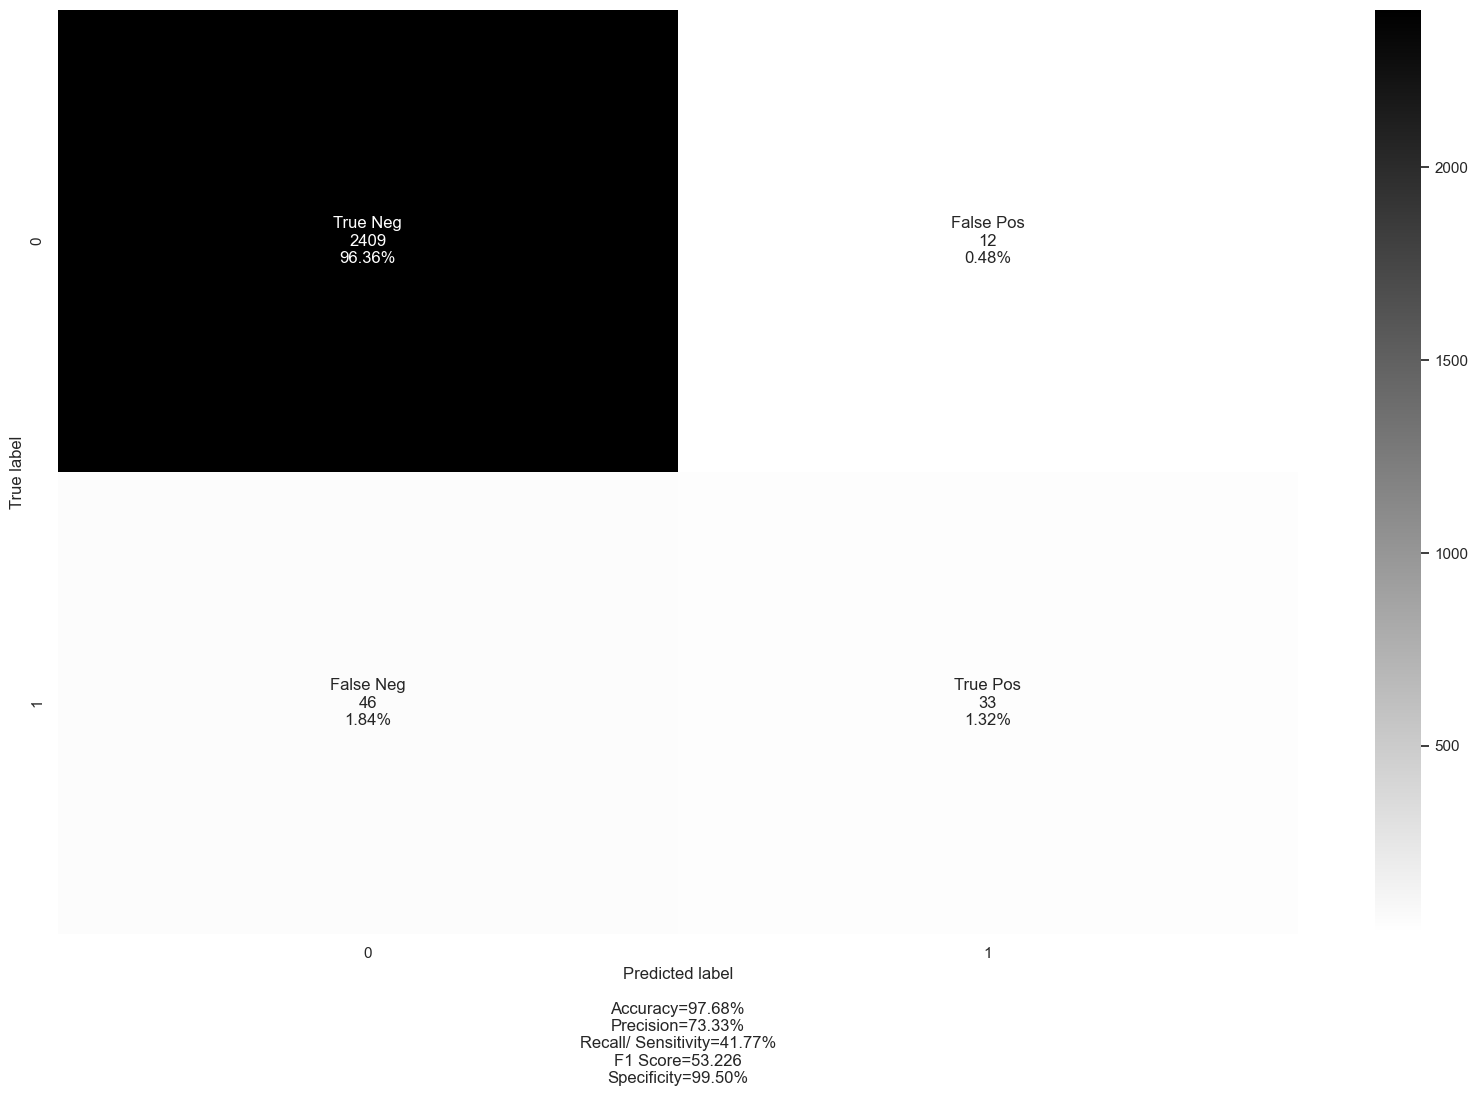

In [18]:
cf_matrix1 = confusion_matrix(y_test2, probs)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf_matrix1, group_names=labels, categories=categories, cmap='binary')

Takeaway: The results of the confusion matrix, especially the high accuracy of 97.68%, shows us that Model 2 is better at predicting the target variable than the benchmark provided by the guru. Though, our recall is much lower and the precision is much higher than the benchmark. This indicates that our model predicts too many False Negatives for the liking of the Guru. To address this issue, we can lower the decision boundary, practically trading false positives for false negatives.

### Lowering the decision boundary

In [57]:
# New prediction with a decision boundary of 0.1 , that is predicting a value of 1 for all probabilities p(x) from the logistic regression greater than 0.1.
probs2 = (results2.predict(exog=X_test2) > 0.1).apply(lambda x: np.int64(x))

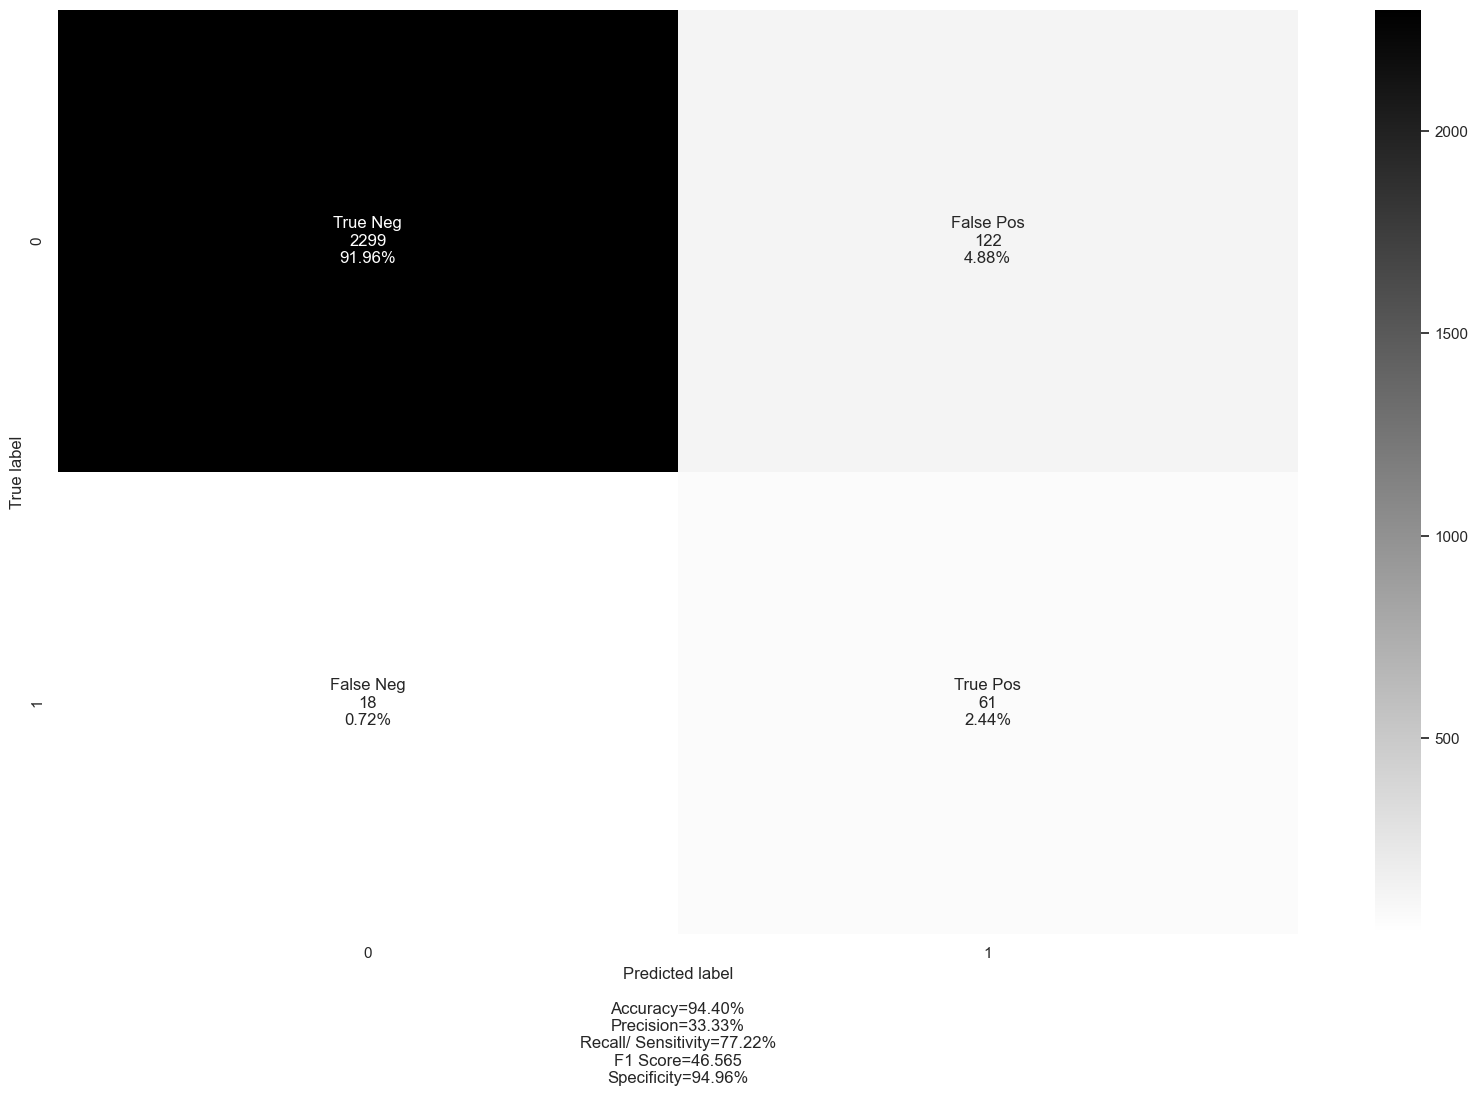

In [58]:
cf_matrix2 = confusion_matrix(y_test2, probs2)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf_matrix2, group_names=labels, categories=categories, cmap='binary')

Takeaway: With the lower decision boundary we make more conservative predictions, that is, we are risk averse and want to avoid predicting false negatives, which in a real problem could be costly. The predision, accuracy and recall for Model 2 are all above the benchmark of the guru. Therefore, we conclude that this model is better than the benchmark.

## b)

# Interpret the results

Interpretation: All variables seem statistically significant due to their p-Values being below 0.05. The variable Monday, which is a binary variable suggests that more failures occur on Mondays. That is, the odds of 'Failure' are 
e^2.5718≈13.07 times higher compared to other days.
Furthermore, a higher Air Temperature also indicates a higher likelihood of failure. More precisely, a one-unit increase in air temperature is associated with a e^1.1735≈3.24 times increase in the odds of 'Failure'.
On the contrary, a lower Process Temperature indicates a lower likelihood of failure. A one-unit increase in process temperature is associated with a e^-0.6266≈0.536 times decrease in the odds of 'Failure'.
The wear of the tools also increases the risk of failure, as well as the rotational speed. A one-unit increase in rotational speed is associated with a e^0.0129≈1.013 times increase in the odds of 'Failure'. We have also included two interaction terms which reduce multicollinearity in the model and help to better capture the relationships between the variables.

Looking at the z-scores, rotational speed and monday have the highest z-scores, indicating that those two variables have the strongest predictive power for the dependent variable. Tool wear and the second interaction term have the lowest absolute z-scores, indicating that the have weakest predictive power, given that all the other variables are also in the model.

# Day 4
### Run a lasso regression with λ = 0, λ = 1, and λ = 3

In [21]:
# Create dummies for each variable
Rides_Daily = pd.read_csv('rides_daily.csv')
Rides_Daily = pd.get_dummies(Rides_Daily, drop_first = True)
# ew Colums with dummy variables have been created, the first (e.g. 'monh;Apr') have been dropped
Rides_Daily.columns

Index(['hour', 'num_rides', 'cloudcover', 'dew', 'feelslike', 'feelslikemax',
       'feelslikemin', 'humidity', 'moonphase', 'precip', 'precipcover',
       'precipprob', 'sealevelpressure', 'severerisk', 'snow', 'snowdepth',
       'solarenergy', 'solarradiation', 'temp', 'tempmax', 'tempmin',
       'uvindex', 'visibility', 'winddir', 'windgust', 'windspeed',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'month_Aug', 'month_Dec', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep'],
      dtype='object')

Remark to the hint of the guru: A lasso regression with Lambda=0 would yield the same results an a least squared regression, since the penality for adding additional variables to the model for lambda=0 is non-existent.

In [22]:
# Define the X values and exclude the dependent variable 'num_rides'
X = Rides_Daily.drop(columns='num_rides')

# Define the dependent variable 'num_rides'
Y = Rides_Daily.num_rides 

# Regulate the strength of the regression
alpha1 = 0 
alpha2 = 1
alpha3 = 3

# Standardize the data, that is subtract the mean and divide by the standard deviation
scaler = StandardScaler()
X_Train = scaler.fit_transform(X)

In [65]:
# Create a dataframe, which includes a column for the variables, for the results of the regression
lasso_regression = pd.DataFrame()
variables = X.columns
lasso_regression["Variables"] = variables

# Since a lasso regression with alpha = 0 makes no sense, we get a User Warning, which can be ignored
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    #Fit a lasso regression for lambda = 0
    lasso = Lasso(alpha=alpha1) 
    model =lasso.fit(X,Y)
    coefs = model.coef_

    #Fit a lasso regression for lambda = 1
    lasso = Lasso(alpha=alpha2) 
    model2 =lasso.fit(X,Y)
    coefs2 = model2.coef_
    
    #Fit a lasso regression for lambda = 3
    lasso = Lasso(alpha=alpha3)
    model3 =lasso.fit(X,Y)
    coefs3 = model3.coef_

# create a column for every lasso regression we performed
lasso_regression['0'] = coefs
lasso_regression['1'] = coefs2
lasso_regression['3'] = coefs3

# replace the zeros in the dataframe with 'not selected'
lasso_regression.replace(0, "not selected", inplace=True)

styled_df = lasso_regression.style
# Apply a custom style to the DataFrame
styled_df = styled_df.set_table_styles([
    {'selector': 'thead', 'props': 'background-color: #91BA44; color: #000000;'},
    {'selector': 'th', 'props': 'text-align: center;'},
    {'selector': 'td', 'props': 'text-align: center;'},
])
# Display the styled DataFrame
styled_df

,Variables,0,1,3
0,hour,3.984245,3.961881,3.918099
1,cloudcover,0.564483,0.520214,0.541598
2,dew,3.903790,3.643093,1.700279
3,feelslike,-3.272885,not selected,not selected
4,feelslikemax,-3.465914,-4.336773,-1.045668
5,feelslikemin,1.646709,not selected,0.178096
6,humidity,-1.741054,-1.612807,-1.082697
7,moonphase,-2.536557,not selected,not selected
8,precip,-0.314041,-0.134319,-0.037175
9,precipcover,-0.249601,-0.338852,-0.366734


In [100]:
columns = lasso_regression.columns[1:]

non_zero_lists = {}
for column in columns:
    non_zero_lists[column] = lasso_regression.loc[lasso_regression[column] != 'not selected', 'Variables'].tolist()
    
for column, non_zero_values in non_zero_lists.items():
    print(f"Variables for lambda = {column}:", non_zero_values,'\n')

Variables for lambda = 0: ['hour', 'cloudcover', 'dew', 'feelslike', 'feelslikemax', 'feelslikemin', 'humidity', 'moonphase', 'precip', 'precipcover', 'precipprob', 'sealevelpressure', 'severerisk', 'snow', 'snowdepth', 'solarenergy', 'solarradiation', 'temp', 'tempmax', 'tempmin', 'uvindex', 'visibility', 'winddir', 'windgust', 'windspeed', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep'] 

Variables for lambda = 1: ['hour', 'cloudcover', 'dew', 'feelslikemax', 'humidity', 'precip', 'precipcover', 'precipprob', 'sealevelpressure', 'severerisk', 'snowdepth', 'solarradiation', 'temp', 'tempmax', 'uvindex', 'visibility', 'winddir', 'windgust', 'windspeed', 'weekday_Sat', 'month_Oct'] 

Variables for lambda = 3: ['hour', 'cloudcover', 'dew', 'feelslikemax', 'feelslikemin', 'humidity', 'precip', 'precipcover'

The cell aboves shows which variables are selected with the Lasso Regression depending on Lambda. We can see that the size of the list, that is the number of variables, decreases as Lambda increases. For Lambda=3 18 out of 42 variables are in the model.

# Day 6
# a)
### Fit a regression tree on the entire dataset using all the variables available to us.

### load the dataset and seperate predictors and the response variable

In [40]:
rides_daily = pd.read_csv('rides_daily.csv')
rides_daily_dum = pd.get_dummies(rides_daily, columns=['weekday', 'month'], drop_first=True) # create dummy variables for 'month' and 'weekday'

X = rides_daily_dum.iloc[:, np.r_[0, 2:len(rides_daily_dum.columns)]] # use all variables except for 'num_rides' as predictors
y = rides_daily_dum[rides_daily_dum.columns[1]] # specify 'num_rides' as dependent variable

### Using grid search with 6-fold cross validation to determine the optimal regression tree parameters

In [41]:
# initialise the regression tree without any parameters except a random state that ensures same results on different machines
new_tree = DecisionTreeRegressor(random_state=99) 

# testing a larger number of combinations increases the  runtime of  the code --> fitting 3000 models takes between 40-90 seconds on our machines
# with  a  high performance computer (or patience) one could test more parameter combinations and likely get a better result

# create a dictionary for the grid search which will test all the possible combinations of the following 5 parameters
param_grid = {
    # we test all different depths of the tree between 1 and the log2(n) which rounded to the lowest integer is 14 for n=23352
    # this parameters controlls how deep the tree can grow --> log2 is the maximum if all leaves were pure
    'max_depth': list(range(1,15)), 

    # we test different minimum sample splits and minimum sample leaves--> these two parameter controll how deep the individal branches of the tree grow
    # these additional restrictions lead to a tree that will not be grown to the maximum depth for all branches
    'min_samples_split': [2, 15, 100],
    'min_samples_leaf': [1,5,20,40],

    # the minimum impurity decrease also controlls if we split further at a given internal node --> only split if the resulting increase of the inpurity is above a threshold
    'min_impurity_decrease': [0.0, 0.025, 0.05], # we tested 0.1 and 0.2 --> worse  than 0.0
    
    # the ccp-alpha parameter determines how much pruning of the tree is performed, the default is 0 
    'ccp_alpha' : [0.0, 0.01]
}


# Measure the start time
start_time = time.time()

# setting n_jobs = -1 (default =None) will allow us to use all the CPU cores simultaneously --> runtime decreases drastically (by more than 50%)
# --> assuming that the other cores are not busy with other things

# performing the grid search with 6-fold cross-validation and our parameter grid to determine the optimal regression tree parameters
# setting verbose=1 will show us the number of models that is fitted
gs_tree2 = GridSearchCV(new_tree, param_grid, cv=6, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

gs_tree2.fit(X, y)

# Measure the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

print("Optimal regression tree hyper-parameters:",*gs_tree2.best_params_.items(), sep='\n\t')
print("\nRuntime:", runtime, "seconds")

Fitting 6 folds for each of 1008 candidates, totalling 6048 fits
Optimal regression tree hyper-parameters:
	('ccp_alpha', 0.0)
	('max_depth', 7)
	('min_impurity_decrease', 0.05)
	('min_samples_leaf', 40)
	('min_samples_split', 100)

Runtime: 187.01254391670227 seconds


## Interpretation of the optimal parameters

The optimal depth is 7, that is, growing the tree deeper will increase the test MSE that is calculated with the cross-validation. This indicates that there is a problem of overfitting when the tree grows deeper than 7.
The optimal combination of minimum sample split and minimum sample leaf is 100 and 40. Those are the two largest amounts we tested for. Again, this indicates that growing all branches to a depth of 7 would increase the test MSE. Having larger leaf sample thus minimizes overfitting which might happen when the nodes are splitted until the leafs are pure, that is a minimum leaf sample of 1.
The optimal value for min_impurity_decrease is 0.05 which is also the largest amount we tested for.
All these parameters restrict how the tree can and when a single branch should not be grown any further (stopping rule).

The value of 0.0 for ccp_alpha indicates that no pruning of the tree is better than pruning given all the restrictions

### Estimating a Regression Tree  with the 'optimal' parameter combination

Number of nodes:  175
Training MSE of the regression tree:  2139.41


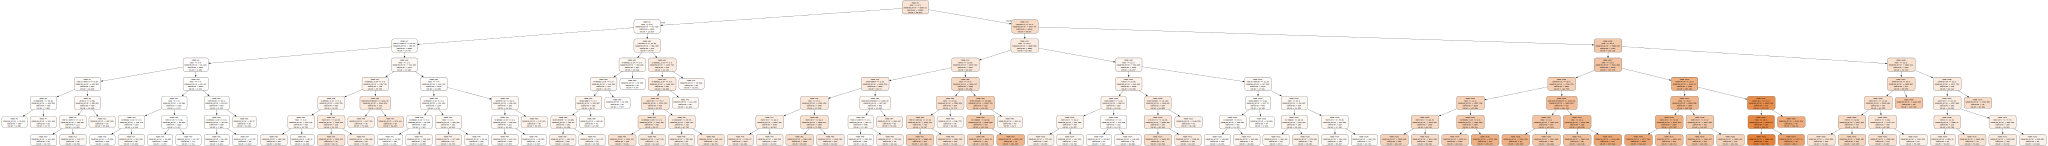

In [42]:
# initialise a regression tree with the parameters above
# since the optimal ccp_alpha is 0.0 we do not have to specify it in the function
reg_tree = DecisionTreeRegressor(max_depth=7, min_impurity_decrease=0.05, min_samples_leaf=40, 
                               random_state=99, min_samples_split=100)

reg_tree = reg_tree.fit(X, y)
train_MSE = np.mean(((reg_tree.predict(X)-y)**2))
# Visualize the tree with Graphviz
dot_data = export_graphviz(reg_tree, feature_names=X.columns, node_ids=True,
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)

# access the node count of the tree
Tree = reg_tree.tree_
print('Number of nodes: ',Tree.node_count)
print('Training MSE of the regression tree: ',train_MSE.round(2))
display(graph)

Takeaway: The training MSE of the tree with the optimal parameters is roughly 2140. The tree node count of 175 shows that not all branches have been grown to the maximum depth of 7, because then the node count would be (1+2+4+8+16+32+64+128) which is 255. Thus, the additional restrictions (parameters) improve the fit compared to the default fit. Interpreting the MSE without a train test split is quite difficult

# b)
### Determining the optimal amount of Trees B, the max_features which represents fraction m parameters that are randomly selected from at each split, the maximum depth of the tree and the minimum sample leafs 

In [96]:
# setting some parameters to be tested in the grid search with 5-fold cross validation
###  Please note that computation is the bottleneck for finding the optimal random forest parameters ###
# with a high performance computer one could likely find a better combination of parameters that minimizes the MSE

parameter_grid = {
    # we test B=5,10,100 --> we also tried B=1000 but the runtime increases significantly while the MSE barely changes
    'n_estimators': [5,10,100], 
    
    # we test m= sqrt(p), 0.5, 0.8 --> we do not test m=1.0 since in a random forest m is lower than p --> adding 0.4, 0.6 or 0.2 does not change the result
    # however, it increases the run-time
    'max_features': ['sqrt', 0.5, 0.8], 
    
    # the optimal depth in a) was 7. So we decided to test the max_depth parameter in a close range around that value to improve the runtime
    'max_depth': [5,6,7,8,9], 
    # we also test another parameter that controls how the tree grows --> but we do not test as many combinations of parameters due to the runtime concern
    'min_samples_leaf': [1,10,40]
    
}

# Measure the start time
start_time = time.time()

# Create a Random Forest Regressor and set a random state so that the results will be the same on different machines
rand_forest = RandomForestRegressor(random_state=99) 

# Perform GridSearchCV with cv=6 (divisor of n between 5 and 10)) and our parameter grid from above
# we set n_jobs=-1 to use als CPU cores and verbose=1 to display the number of models that are fitted
grid_rf = GridSearchCV(rand_forest, parameter_grid, cv=6, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_rf.fit(X, y)


# Access the results
results = grid_rf.cv_results_

# Measure the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Print results
print("\nOptimal Random Forest hyper-parameters:", *grid_rf.best_params_.items(), sep='\t\n')
print("\nRuntime:", runtime, "seconds")

Fitting 6 folds for each of 135 candidates, totalling 810 fits

Optimal Random Forest hyper-parameters:	
('max_depth', 7)	
('max_features', 0.8)	
('min_samples_leaf', 10)	
('n_estimators', 100)

Runtime: 218.2381227016449 seconds


Comment on optimal parameters: The optimal depth is 7 which is equal to the result in a). The max_features, that is, the optimal value for m is 0.8. That means only 80% of the randomly selected p parameters can be used as a splitting criterium at any given split. The ideal minimum size of the leaves is 10 which is lower than in a) where had more restrictions for the growth of the tree, though.
The optimal value for B (n_estimators) is 100 which is not a surprise, since one would expect the MSE to decrease as B increases. 


# Fitting a random forest model with the optimal parameters from the grid search

In [97]:
# initialise and fit a random forest with the optimal parameters from above
rand_forest = RandomForestRegressor(max_depth=7, max_features=0.8, random_state=99, n_estimators=100, min_samples_leaf=10)
rand_forest = rand_forest.fit(X, y)


# calculate the training mean squared error resulting from the fitted random forest
train_MSE = np.mean(((rand_forest.predict(X)-y)**2))
print(f'The training MSE is: {train_MSE.round(4)}')

The training MSE is: 1928.6208


Answer: The training MSE for this random forest is roughly 1929 compared to a training MSE of roughly 2140 for the regression tree in a). However, comparing these 2 scores to determine which model is better is not sufficient. In general, comparing the results of these two methods is quite tricky, since we did not have all  the restrictions in b) as the compuation already takes 4 minutes, testing all the parameters from a) would increase the runtime to at least 20 minutes. Yet, the optimal depth of the tree is 7 for both methods and the training MSE for the random forest is lower which somewhat confirms the theory behind random forests albeit our model uses 80% of the features which is the maximum we tested. This indicates that randomly leaving out a majority of parameters would lead to a worse  model fit. Given the first OLS regression we performed for Day 2 this is not surprising, because the three variables 'hour', 'month' and 'weekday' explain most of the variance out of all predictors. Recall that the training MSE for our OLS Regression from Day 2 was 3079, so compared to that both the random forest and the regression tree in a) performed better on the training data, which is not surprising since more flexible methods generally perform better on the training data. Whether  or not they perform better on test data is yet to be determined.

# c)

# Plot the feature importance for the regression tree

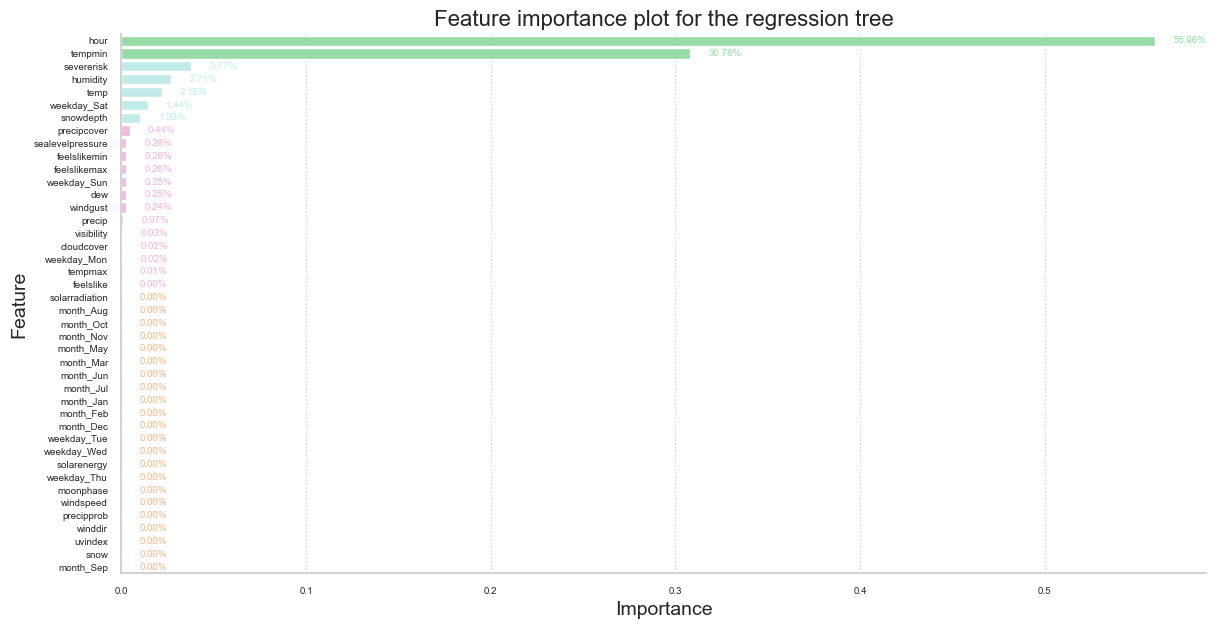

In [98]:
plot_df1 = pd.DataFrame({'feature': X.columns, 'importance': reg_tree.feature_importances_})

# Sort the DataFrame by importance of the features
plot_df1 = plot_df1.sort_values('importance', ascending=False)

# set a whitegrid background
sns.set_theme(style="whitegrid")

# Set a color palette for different feature importance (1% and 10%)
pastel_palette = sns.color_palette("pastel", n_colors=10) # get the pastel color theme to select 4 distinct colors
custom_palette = [pastel_palette[2] if x > 0.2 else pastel_palette[9] if x > 0.01
                  else pastel_palette[6] if x>0.0 else pastel_palette[1] for x in plot_df1['importance']]

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='importance', y='feature', data=plot_df1, palette=custom_palette)

# Add a title
plt.title('Feature importance plot for the regression tree', fontsize=16)

# Add labels
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Customize tick labels
ax.tick_params(axis='x', labelsize=7)
ax.set_yticklabels(ax.get_yticklabels(), size=7)

# Customize grid lines
ax.grid(axis='x', linestyle=':', alpha=0.9)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotations with colors matching the bars
for i, p in enumerate(ax.patches):
    color = custom_palette[i]
    ax.annotate(f'{p.get_width():.2%}', (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=7, color=color)


Interpretation: The four different colours of the bars in the plot group the features into groups based on their importance.
The feature importance quantifies  how much each feature increases the purity of the model, that is, how much it reduces the error. 
The orange features which are 20 out of 42 have a feauture importance of 0.0 or lower. Hence, they basically do not contribute to improving the purity of the nodes in the tree, because are only used rarely or never at all as splitting criterium.
They could be removed from the model without causing the MSE to increase visuably.

The pink features which are 13 out of 42 also have  weak predictive power, that is, their importance is between 0.1 and 1%. They are also not commonly used as a splitting criterium by the algorithm, however, they do improve the MSE and should not be removed from the model.

The blue features which are 5 out of 42 have intermediate importance to the model. In this case they have an importance between 1% and 4%. In sum, they increase the purity of the tree by roughly 10%. This indicates that they are just more commonly as a splitting criterium than the two groups with lower importance albeit most likely not in the crown of the tree. Without looking at the tree, one would expect to see these 5 variables used as splitting criteriums in the lower regions of the tree where the nodes are already fairly pure.

The two green features 'hour' and 'tempmin' are the most important features of the tree. Combined, they increase the purity of the tree by roughly 87%. This indicates that they are used right at the top and on the level below that as splitting criteriums when the nodes still have the highest impurity. They are indispensable for the model and thus must have the strongest predictive power of the model. 

# Plot the feature importance for the random forest

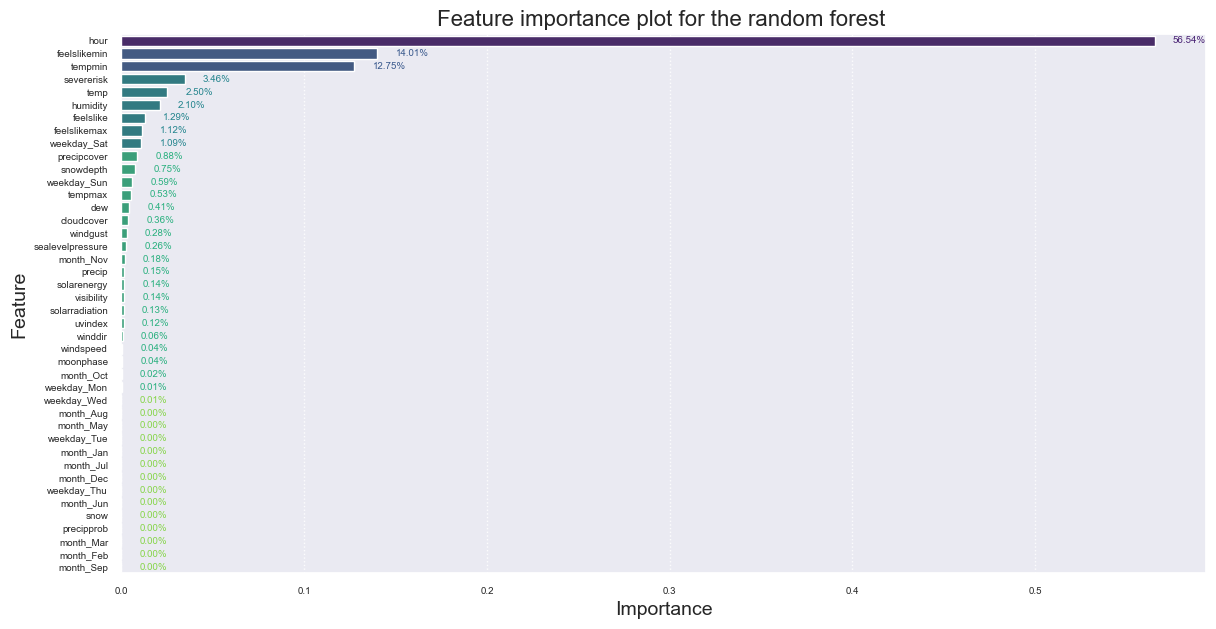

In [99]:
plot_df2 = pd.DataFrame({'feature': X.columns, 'importance': rand_forest.feature_importances_})

# Sort the DataFrame by importance of the features
plot_df2 = plot_df2.sort_values('importance', ascending=False)

# set a darker background
sns.set_theme(style="darkgrid")

# Set a color palette for different feature importance (1% and 10%)
viridis_palette = sns.color_palette("viridis", n_colors=10) # get the viridis color theme to select 5 distinct colors
custom_palette_2 = [viridis_palette[0] if x > 0.2 else viridis_palette[2]  if x > 0.1 else viridis_palette[4] if x > 0.01
                  else viridis_palette[6] if x>0.0001 else viridis_palette[8] for x in plot_df2['importance']]

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='importance', y='feature', data=plot_df2, palette=custom_palette_2)

# Add a title
plt.title('Feature importance plot for the random forest ', fontsize=16)

# Add labels
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Customize tick labels
ax.tick_params(axis='x', labelsize=7)
ax.set_yticklabels(ax.get_yticklabels(), size=7)

# Customize grid lines
ax.grid(axis='x', linestyle=':', alpha=0.9)

# Add annotations with matching colors
for i, p in enumerate(ax.patches):
    color = custom_palette_2[i]
    ax.annotate(f'{p.get_width():.2%}', (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=7, color=color)

Interpretation: The five different colours of the bars in the plot group the features into groups based on their importance. Since fewer variables have virtually no importance to the model compared to the regression tree above, there are 5 groups instead of 4.

The light green features which are 14 out of 42 have a feauture importance of 0.0 or lower. Hence, they basically do not contribute to improving the purity of the nodes in the trees of the random forest, because are only used rarely or never at all as splitting criterium in any of the 100 trees.Again, they could be removed from the model without causing the MSE to increase measurably.

The darker green features which are 19 out of 42 also have weak predictive power, that is, their importance is between 0.1 and 1%. They are also not commonly or if at all used , then towards to bottom of the tree, as a splitting criterium by the algorithm. However, they do improve the training MSE and should not be removed from the model. Compared to the regression tree, this group is larger which is due to the fact that only 80% of features can be chosen from as a splitting criterium at a given node. This increases the chance of a weaker feauture being the best feature for splitting if the most dominant features are not available as a splitting criterium.

The bluish green features which are 6 out of 42 have intermediate importance to the model. In this case they have an importance between 1% and 4%. In sum, they increase the purity of the tree by roughly 12,5%. This indicates that they are just more commonly as a splitting criterium than the two groups with lower importance albeit most likely not in the crown of any of the 100 trees in the forest . Compared to the regression tree, this group has also become larger (10% to 12.5%) which is to be expected, when the two most dominant features are not available as a splitting criterium at the crown of a single tree in 20% of the cases (m=0.8).  

The two dark blue features 'feelslikemin' and 'tempmin' have a combined importance of roughly 27%.
This indicates that they are used right at the top and on the two levels below that as splitting criteriums in a majority of the trees when the nodes still have a high impurity. They are indispensable for the model and thus must have the strongest predictive power of the model.

Surpringsly, the violet feature 'hour' is an even more 'dominant' feature in the random forest compared to the regression tree.
It contributes to more than 50% of the  decrease in impurity in the forest. This is quite surprising, since one would expect that this feature cannot be used as a splitting criterium at the crown of the tree in 20% of the trees (m=0.8). This, however, confirmes that this feature is the single most important predictor of the model. 

Comparison: The feature importance for these 2 methods look quite similar with 2 and 3 feautures respectively contributing to the majority of decrease in inpurity. However, in the random forest more features are used as spitting criteria and the variable 'tempmin' is less important than in the regression tree. All the lower groups have a higher sum of feature importances in the random forest, but 'hour' remains a very dominant feature. For a lower value of m one would expect the feature importance of the variables with low predictive power like 'uvindex' to increase whereas dominant features like 'hour' would decrease.

# Comparison to Lasso Regression

In [129]:
# get the results for the lasso regression from day 4 and filter the data frame for all the variables selected for lambda = 3
lasso_res = lasso_regression[lasso_regression['3'] != 'not selected']
lasso_3= lasso_res.sort_values(by='3', ascending=False)

# display the dataframe
lasso_3


,Variables,0,1,3
0,hour,3.984245,3.961881,3.918099
17,temp,6.955861,2.012623,2.786266
2,dew,3.903790,3.643093,1.700279
11,sealevelpressure,0.602659,0.795681,0.693283
12,severerisk,0.648119,0.644445,0.657391
1,cloudcover,0.564483,0.520214,0.541598
20,uvindex,4.388912,3.165775,0.472828
23,windgust,0.231854,0.208356,0.194078
5,feelslikemin,1.646709,not selected,0.178096
10,precipprob,0.098230,0.063028,0.054945


Interpretation: The Lasso Regression for lambda=3 selects 18 out of 42 variables whereas the regression tree selects 22 and the random forest even selects 28.
In all three methods, however, 'hour' is the most important feature. Most of the feautures that are not included in the regression tree and random forest - like most of the dummy variables for 'month' and for 'weekday' are also not included in the Lasso Regression. So the set of predictors looks quite similar, with the exception that the random forest and regression tree use more of the predictors but those do not included any predictors that reduce the impurity of the tree significantly. The variables with larger coefficients like 'temp' or 'dew' do not seem to very important in the tree based methods. So they are similar insofar that 'hour' is the strongest predictor in all 3 methods and most of the variables overlap, however the higher coefficients in the Lasso table do not  visuably correspond to a higher feature importance in the two tree based methods.
One important distinction is that the Lasso regression selects a smaller subset of predictors than the other two methods, which is to be expected given that it is a much more restrictive statistical learning method.